In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import sys
import os

sys.path.append(os.path.relpath("../../huygens"))
sys.path.append(os.path.relpath("../../galileo"))

import galileo as gal
import huygens as huy

# Transcripts to genes

In [3]:
t2g = pd.read_csv("../data/intermediate/sleuth_diff/ensembl_t2g.csv")
t2g["format_gene_id"] = t2g["hgnc_gene"].fillna("") + "_" + t2g["ens_gene"]

format_gene_map = dict(zip(t2g["ens_gene"],t2g["format_gene_id"]))

# Proprocess TCGA

In [4]:
tcga_a3ss = pd.read_hdf("../data/processed/tcga/tcga_a3ss.hdf",key="tcga_a3ss")
tcga_se = pd.read_hdf("../data/processed/tcga/tcga_se.hdf",key="tcga_se")
tcga_genex = pd.read_hdf("../data/processed/tcga/tcga_genex.hdf",key="tcga_genex")
tcga_cn = pd.read_hdf("../data/processed/tcga/tcga_cn.hdf",key="tcga_cn")
tcga_muts = pd.read_hdf("../data/processed/tcga/tcga_muts.hdf",key="tcga_muts")

In [5]:
tcga_a3ss.index = tcga_a3ss.index.map(lambda x: x[:15])
tcga_se.index = tcga_se.index.map(lambda x: x[:15])

tcga_a3ss = tcga_a3ss[~tcga_a3ss.index.duplicated(keep="first")]
tcga_se = tcga_se[~tcga_se.index.duplicated(keep="first")]

tcga_genex.columns = [format_gene_map.get(x.split(".")[0],"unnamed")+"_"+x for x in tcga_genex.columns]
tcga_a3ss.columns = [format_gene_map.get(x.split(".")[0],"unnamed")+"_"+x for x in tcga_a3ss.columns]
tcga_se.columns = [format_gene_map.get(x.split(".")[0],"unnamed")+"_"+x for x in tcga_se.columns]

## RPL22 mutants

In [22]:
rpl22_mut = pd.Series(index = sorted(set(tcga_muts.index)))

damaging_effects = ["Frame_Shift_Del",
                    "Frame_Shift_Ins",
                    "Nonsense_Mutation",
                    "Nonstop_Mutation",
                    "Splice_Site",
                    "Translation_Start_Site",
                    "large deletion"
                    ]

truncated = tcga_muts[(tcga_muts["gene"] == "RPL22")]
truncated = truncated[truncated["effect"].isin(damaging_effects)].index
truncated = set(truncated)

rpl22_mut = pd.Series(rpl22_mut.index.map(lambda x: x in truncated), index=rpl22_mut.index)
rpl22_mut.name = "RPL22_trunc"

In [24]:
rpl22_info = pd.concat([rpl22_mut,
                        tcga_cn["RPL22"].rename("RPL22_cn")],
                       axis=1,
                       sort=True,
                       join="inner"
                      )

In [84]:
def rpl22_status(row):
    if row["RPL22_trunc"]:
        return "Truncating\nmutation"
    
    else:
        return "CN = " + str(int(row["RPL22_cn"]))

rpl22_info["RPL22_status"] = rpl22_info.apply(rpl22_status, axis=1)

rpl22_order = ["Truncating\nmutation","CN = -2", "CN = -1", "CN = 0", "CN = 1", "CN = 2"]

mut_hue = "#e23e57"
wt_hue = "#eaeaea"

rpl22_hues = {
    "Truncating\nmutation" : mut_hue,
    "CN = -2" : wt_hue, 
    "CN = -1" : wt_hue, 
    "CN = 0" : wt_hue, 
    "CN = 1" : wt_hue, 
    "CN = 2" : wt_hue
}

In [85]:
def plot_rpl22(y, ylabel="y"):

    plt.figure(figsize=(6,4))

    ax = plt.subplot(111)
    
    rpl22_info_join = rpl22_info.join(y.dropna(),how="inner")
    
    rpl22_counts = rpl22_info_join["RPL22_status"].value_counts()

    sns.boxplot(
        rpl22_info["RPL22_status"],
        y,
        notch=True,
        order = rpl22_order,
        bootstrap = 1000,
        palette = rpl22_hues
    )

    plt.xlabel("RPL22 status")
    plt.ylabel(ylabel)

    xticks = [x + "\n ("+str(int(rpl22_counts.loc[x]))+")" for x in rpl22_order]

    ax.set_xticklabels(xticks)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

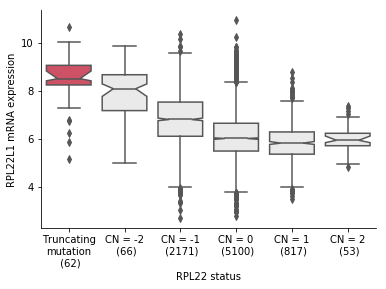

In [86]:
plot_rpl22(tcga_genex["RPL22L1_ENSG00000163584_ENSG00000163584.17"],
           "RPL22L1 mRNA expression"
          )

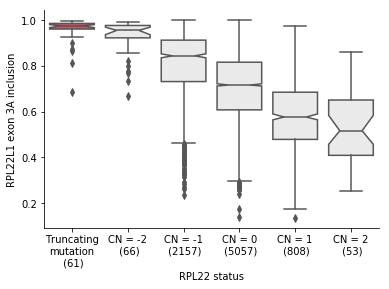

In [87]:
plot_rpl22(tcga_a3ss["RPL22L1_ENSG00000163584_ENSG00000163584.13_A3_3_170586086:170586168:170585801:170585923:170585801:170585990_170585923:170585990"],
          "RPL22L1 exon 3A inclusion"
          )

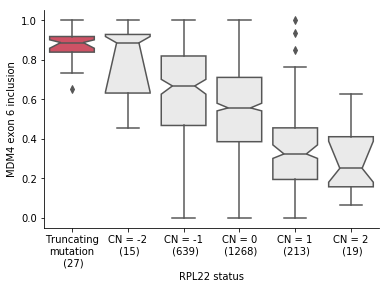

In [88]:
plot_rpl22(tcga_se["MDM4_ENSG00000198625_ENSG00000198625.8_ES_1_204501318:204501374:204506557:204506625:204507336:204507436_204506557:204506625"],
          "MDM4 exon 6 inclusion",
          )